In [81]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely

In [82]:
from general_functions import *

# HD

In [83]:
#define relative paths
waterschap = 'Hollandse_Delta'
data_path = "../../Data_preprocessed/Waterschappen/Hollandse_Delta/Hollandse_Delta_aangepast.gpkg"
output_gpkg_path = "../../Data_postprocessed/Waterschappen/Hollandse_Delta"

In [84]:
HD = read_gpkg_layers(gpkg_path = data_path, 
                        variables = ['stuwen', 
                                     'gemalen', 
                                     'afsluitmiddelen',
                                     'sluizen',
                                     'HydroObjectWatergangtype', #= hydroobject
                                     'HydroObjectKunstwerkvakken']) #= duikersifonhevel

#change names
HD['stuw'] = HD.pop('stuwen')
HD['gemaal'] = HD.pop('gemalen')
HD['afsluitmiddel'] = HD.pop('afsluitmiddelen')
HD['sluis'] = HD.pop('sluizen')
HD['hydroobject'] = HD.pop('HydroObjectWatergangtype')
HD['duikersifonhevel'] = HD.pop('HydroObjectKunstwerkvakken')
                                     


In [85]:
#see the readme: peilgebieden have not be delivered properly. This data is retrieved from an external online database.
# peilgebieden_path = '../../Data_preprocessed/Waterschappen/Hollandse_Delta/WSHD_Peilgebieden_(Vigerend).shp'
peilgebieden_path_all =  "../../Data_preprocessed/Waterschappen/Hollandse_Delta/Nalvering_tweede/Shapefiles/PeilgebiedenPraktijk.shp"
peilgebieden_path_geen_AP =  "../../Data_preprocessed/Waterschappen/Hollandse_Delta/Nalvering_tweede/Shapefiles/PeilgebiedenGeenAP.shp"

#load in both the old ones and the new ones, as the new ones do not have the peilgebiedafwijkingen, but they dont have the streefpeilen. These are stored in the old ones.
peilgebieden_all = gpd.read_file(peilgebieden_path_all)
peilgebieden_all = peilgebieden_all[~peilgebieden_all['CODE'].str.contains('.AP')]

peilgebieden_geen_AP = gpd.read_file(peilgebieden_path_geen_AP)

peilgebieden = pd.merge(left=peilgebieden_geen_AP,
                        right=peilgebieden_all,
                        left_on='Dis',
                        right_on='Dis',
                        suffixes=('', '_all'),
                        how='left')

#add the shapefile to the dictionary
HD['peilgebied'] = peilgebieden.drop_duplicates(subset='Dis')

## Add aggregation areas

In [86]:
#Load the additional data
KRW = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Hollandse_Delta\Nalvering_tweede\Shapefiles\KRW-vlak.shp")
# aggregation_area = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Hollandse_Delta\Nalvering_tweede\Shapefiles\Aanvoergebieden.shp")

In [87]:
aggregation_area = HD['peilgebied']
aggregation_area['code'] = aggregation_area['CODE']
aggregation_area['nen3610id'] = aggregation_area['NAAM_BEMAL']
aggregation_area['globalid'] = 'dummy_globalid_agg_area_' + aggregation_area.index.astype(str)
aggregation_area = aggregation_area[['code', 'nen3610id', 'globalid', 'geometry']]

In [88]:
KRW['code'] = KRW['OWMIDENT']
KRW['nen3610id'] = KRW['OWMNAAM']
KRW['globalid'] = 'dummy_globalid_KRW_' + KRW.index.astype(str)
KRW = KRW[['code', 'nen3610id', 'globalid', 'geometry']]

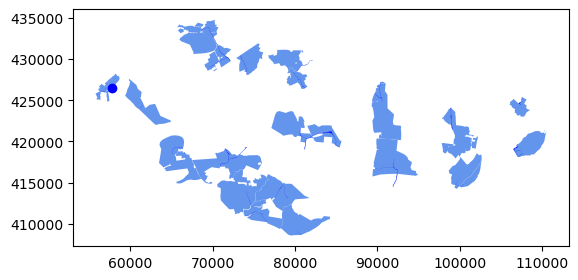

In [89]:
codes = """P-G13.004
P-G12.008
P-G22.005
P-G33.008
P-G42.001
P-G44.005
P-H02.001
P-V03.005
P-V05.008
P-V06.010
P-V06.010
P-H03.002
P-H04.002
P-H17.009
P-H18.001
P-H18.002
P-D21.006
P-D27.006
P-G43.006
P-G32.007
P-V01.010
P-V01.022
"""
code_list = [code.strip() for code in codes.strip().split("\n") if code.strip()]

agg_area_dont_split = aggregation_area[~aggregation_area.code.isin(code_list)]
agg_area_to_split = aggregation_area[aggregation_area.code.isin(code_list)]
clipped_KRW = gpd.clip(KRW, agg_area_to_split)

burned_in_areas = burn_in_peilgebieden(base_layer=agg_area_to_split,
                                    overlay_layer=clipped_KRW)
aggregation_area = aggregation_area.dropna(subset='geometry')

In [90]:
KRW_to_add = gpd.clip(clipped_KRW, agg_area_to_split).reset_index(drop=True) #these KRW bodies are cut out, so they need to be inserted again
KRW_to_add = gpd.clip(KRW_to_add, HD['peilgebied'])#.dropna().explode(ignore_index = True) #however, they may cross multiple peilgebieden with different peilen. clip it on the peilgebieden
KRW_to_add = KRW_to_add.explode(ignore_index=True) #explode
KRW_to_add = KRW_to_add[KRW_to_add.geometry.type.isin(['Polygon', 'MultiPolygon'])].reset_index(drop=True) #discard points, linestrings, and geometry collections
KRW_to_add = gpd.GeoDataFrame(data = KRW_to_add, columns=['geometry'])
KRW_to_add = gpd.sjoin(left_df = KRW_to_add,
                       right_df = HD['peilgebied'][['REKENPEIL1', 'geometry']],
                       how = 'left',
                       predicate = 'within').reset_index(drop=True)

indices_to_dissolve = [18, 19]

# Extract the rows for these indices
rows_to_dissolve = KRW_to_add.loc[indices_to_dissolve]

# Dissolve the selected polygons into a single polygon
dissolved_polygon = rows_to_dissolve.unary_union

# Create a new GeoDataFrame for the dissolved polygon
new_row = gpd.GeoDataFrame({'geometry': [dissolved_polygon]}, index=[min(indices_to_dissolve)])

# Drop the original rows from the GeoDataFrame
KRW_to_add = KRW_to_add.drop(index=indices_to_dissolve)
KRW_to_add = KRW_to_add.append(new_row, ignore_index=False).reset_index(drop=True)


C:\Users\Bruijns\AppData\Local\Temp\ipykernel_3564\901116719.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  KRW_to_add = KRW_to_add.append(new_row, ignore_index=False).reset_index(drop=True)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [91]:
KRW_to_add.loc[0, 'REKENPEIL1'] = -0.9
KRW_to_add.loc[3, 'REKENPEIL1'] = -1.0
KRW_to_add.loc[6, 'REKENPEIL1'] = -1.75
KRW_to_add.loc[7, 'REKENPEIL1'] = -1.00
KRW_to_add.loc[11, 'REKENPEIL1'] = -1.40
KRW_to_add.loc[12, 'REKENPEIL1'] = -0.95
KRW_to_add.loc[15, 'REKENPEIL1'] = -2.65
KRW_to_add.loc[17, 'REKENPEIL1'] = -2.25
KRW_to_add.loc[18, 'REKENPEIL1'] = -2.0
KRW_to_add.loc[22, 'REKENPEIL1'] = -1.2
KRW_to_add.loc[26, 'REKENPEIL1'] = -2.0


In [92]:
KRW_to_add = KRW_to_add.dropna(subset='REKENPEIL1').reset_index()
KRW_to_add['REKENPEIL_'] = KRW_to_add['REKENPEIL1']
KRW_to_add['NAAM_BEMAL'] = 'KRW_body_' + KRW_to_add.index.astype(str)
HD['peilgebied'] = pd.concat([HD['peilgebied'], KRW_to_add])

In [93]:
aggregation_area = pd.concat([burned_in_areas, agg_area_dont_split])
aggregation_area = gpd.GeoDataFrame(aggregation_area, geometry = 'geometry')
aggregation_area = aggregation_area[(aggregation_area.geom_type == 'Polygon') | (aggregation_area.geom_type == 'MultiPolygon')]
HD['aggregation_area'] = aggregation_area

### Adjust column names

In [94]:
#determine aanvoer en afvoer gemalen
HD['gemaal']['func_aanvoer'], HD['gemaal']['func_afvoer'], HD['gemaal']['func_circulatie']  = False, False, False #default is False
HD['gemaal']['functiegemaal'] = HD['gemaal']['FUNCTIEGEM'].astype(str) 
HD['gemaal'].loc[HD['gemaal']['functiegemaal'] == 'Onbekend', 'functiegemaal'] = np.nan #replace onbekend with nan, will be filled up later see one line below
HD['gemaal']['functiegemaal'].fillna(HD['gemaal']['NAAM'], inplace = True) #some additional information may given in this column
HD['gemaal']['functiegemaal'] = HD['gemaal']['functiegemaal'].astype(str) #again, otherise issue True False

HD['gemaal'].loc[HD['gemaal'].functiegemaal.str.contains('f-|fvoer|nderbemaling'), 'func_afvoer'] = True
HD['gemaal'].loc[HD['gemaal'].functiegemaal.str.contains('anvoergemaal|pmaling'), 'func_aanvoer'] = True
HD['gemaal'].loc[HD['gemaal'].functiegemaal.str.contains('Doorspoel'), 'func_circulatie'] = True
HD['gemaal'].loc[(HD['gemaal'].func_afvoer == False) &
                       (HD['gemaal'].func_aanvoer == False) &
                       (HD['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [95]:
#discard irrelevant data of HD HD, and create a uniform dataset compared to the other waterschappen
#Stuw
HD['stuw'] = HD['stuw'][['CODE', 'GLOBALID', 'geometry']]
HD['stuw'] = HD['stuw'].rename(columns={'CODE': 'code', 'GLOBALID': 'globalid'})
HD['stuw']['nen3610id'] = 'dummy_nen3610id_stuw_' + HD['stuw'].index.astype(str)

#Gemaal
HD['gemaal'] = HD['gemaal'][['CODE', 'GLOBALID', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
HD['gemaal'] = HD['gemaal'].rename(columns={'GLOBALID': 'globalid',
                                            'CODE': 'code'})
HD['gemaal']['nen3610id'] = 'dummy_nen3610id_gemaal_' + HD['gemaal'].index.astype(str)

#Hydroobject
HD['hydroobject'] = HD['hydroobject'][['CODE', 'GLOBALID', 'geometry']]
HD['hydroobject'] = HD['hydroobject'].rename(columns={'GLOBALID': 'globalid',
                                                      'CODE': 'code'})
HD['hydroobject']['nen3610id'] = 'dummy_nen3610id_hydroobject_' + HD['hydroobject'].index.astype(str)

#sluis
HD['sluis'] = HD['sluis'][['CODE', 'GLOBALID', 'geometry']]
HD['sluis'] = HD['sluis'].rename(columns={'GLOBALID': 'globalid'})
HD['sluis']['nen3610id'] = 'dummy_nen3610id_sluis_' + HD['sluis'].index.astype(str)

#duikersifonhevel
HD['duikersifonhevel'] = HD['duikersifonhevel'][['CODE', 'GLOBALID', 'geometry']]
HD['duikersifonhevel'] = HD['duikersifonhevel'].rename(columns={'CODE':'code', 'GLOBALID': 'globalid'})
HD['duikersifonhevel']['nen3610id'] = 'dummy_nen3610id_duikersifonhevel_' + HD['duikersifonhevel'].index.astype(str)

#afsluitmiddel
HD['afsluitmiddel'] = HD['afsluitmiddel'][['CODE', 'geometry']]
HD['afsluitmiddel'] = HD['afsluitmiddel'].rename(columns={'CODE':'code'})
HD['afsluitmiddel']['nen3610id'] = 'dummy_nen3610id_afsluitmiddel_' + HD['afsluitmiddel'].index.astype(str)
HD['afsluitmiddel']['globalid'] = 'dummy_globalid_afsluitmiddel_' + HD['afsluitmiddel'].index.astype(str)

#Peilgebied
HD['peilgebied'] = HD['peilgebied'].reset_index(drop=True)
HD['peilgebied'] = HD['peilgebied'][['REKENPEIL_', 'NAAM_BEMAL', 'geometry']]
HD['peilgebied']['nen3610id'] = 'dummy_nen3610id_peilgebied_' + HD['peilgebied'].index.astype(str)
HD['peilgebied']['globalid'] = 'dummy_globalid_peilgebied_' + HD['peilgebied'].index.astype(str)
HD['peilgebied'] = HD['peilgebied'].rename(columns={'REKENPEIL_': 'streefpeil', 'NAAM_BEMAL':'code'})
HD['peilgebied'].code = HD['peilgebied'].code.astype(str) + '_' + HD['peilgebied'].index.astype(str)

#Streefpeil
HD['streefpeil'] = pd.DataFrame()
HD['streefpeil']['waterhoogte'] = HD['peilgebied']['streefpeil']
HD['streefpeil']['globalid'] = HD['peilgebied']['globalid']
HD['streefpeil']['geometry'] = None
HD['streefpeil'] = gpd.GeoDataFrame(HD['streefpeil'], geometry = 'geometry')

#Remove the streefpeil from the peilgebied
HD['peilgebied'] = HD['peilgebied'][['code', 'geometry', 'nen3610id', 'globalid']]
HD['streefpeil'].waterhoogte = HD['streefpeil'].waterhoogte.round(2)

In [96]:
print(len(HD['peilgebied'].code.unique()))
print(len(HD['peilgebied'].globalid.unique()))

798
798


In [97]:
print(len(HD['peilgebied'].code))
print(len(HD['peilgebied'].globalid))

798
798


## Delete irrelevant data

In [98]:
#delete irrelvant data
variables = ['peilgebiedpraktijk']

for variable in variables:
    if str(variable) in HD:
        del HD[variable]

### Check for the correct keys and columns

In [99]:
show_layers_and_columns(waterschap = HD)

stuw
['code' 'globalid' 'geometry' 'nen3610id']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'globalid' 'func_afvoer' 'func_aanvoer' 'func_circulatie'
 'geometry' 'nen3610id']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

afsluitmiddel
['code' 'geometry' 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

sluis
['CODE' 'globalid' 'geometry' 'nen3610id']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'geometry' 'nen3610id']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'globalid' 'geometry' 'nen3610id']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

peilgebied
['code' 'geometry' 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

aggregation_area
['code' 'nen3610id' 'globalid' 'geometry']
type =  

### Store data

In [100]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = HD, 
           output_gpkg_path = output_gpkg_path + '/HD')
